# Spaceship Titanic dataset (Kaggle)


Variables description:

- `PassengerId`: unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.
 
- `HomePlanet`: The planet the passenger departed from, typically their planet of permanent residence.
 
- `CryoSleep`: Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

- `Cabin`: The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

- `deck`, `num`, `side`: The deck, num and side information from **Cabin** column.
  
- `Destination`: The planet the passenger will be debarking to.

- `Age`: The age of the passenger.
  
- `VIP`: Whether the passenger has paid for special VIP service during the voyage.

- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`: Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

- `Name`: The first and last names of the passenger.

- `Transported`: Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

-  `group`: The group the passenger is travelling with.

- `group_n`: The number within the group (people in the same group are often family members, but not always).

- `group_size`: The size of the group the passenger is travellin with (integer: 1 to 8).

- `group_size_bin`: The size of the group the passenger is travellin with (category: "g1", "g2", "g3", "g4more", for 1, 2, 3 or 4-or-more, respectively).

- `amenities_sum`, `amenities_mean`, `amenities_min`, `amenities_max`: The sum, mean, minimum and maximum of luxury amenities (from columns **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck**)

- `amenities_sum_bin`: The discrete intervals of **amenities_sum** column, where *low*=0, *medium*=(0,1450], *high*=(1450,np.inf]. The value "1450" is the 3rd quartile of **amenities_sum**.

# Load libraries

In [1]:
from pathlib import Path
import sys
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.model_selection import GridSearchCV

np.random.seed(123)

# Python version
print(f"sys: {sys.version}")
print(f"numpy: {np.__version__}")
print(f"scipy: {scipy.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborns {sns.__version__}")

sys: 3.9.5 (tags/v3.9.5:0a7dcbd, May  3 2021, 17:27:52) [MSC v.1928 64 bit (AMD64)]
numpy: 1.24.2
scipy: 1.10.1
pandas: 1.5.3
matplotlib: 3.7.1
seaborns 0.12.2


# Load data

In [2]:
# Load the dataset
def load_ds(path: Path, filename: str) -> pd.DataFrame:
    """Read the dataset csv file as a pandas dataframe."""
    return pd.read_csv(path / filename)

# Load dataset
dataset_path = Path().absolute() / "data"
filename = "X_y_train.csv"
X_y_train = load_ds(dataset_path, filename)
print(f"Shape: {X_y_train.shape}")

Shape: (6954, 14)


In [3]:
print(X_y_train.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


In [4]:
X_y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6954 entries, 0 to 6953
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6954 non-null   object 
 1   HomePlanet    6789 non-null   object 
 2   CryoSleep     6782 non-null   object 
 3   Cabin         6795 non-null   object 
 4   Destination   6805 non-null   object 
 5   Age           6809 non-null   float64
 6   VIP           6800 non-null   object 
 7   RoomService   6801 non-null   float64
 8   FoodCourt     6796 non-null   float64
 9   ShoppingMall  6788 non-null   float64
 10  Spa           6808 non-null   float64
 11  VRDeck        6809 non-null   float64
 12  Name          6786 non-null   object 
 13  Transported   6954 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 713.2+ KB


In [5]:
X_y_train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,7527_01,Earth,False,F/1561/P,TRAPPIST-1e,18.0,False,0.0,732.0,2.0,13.0,47.0,Elle Flowensley,True
1,7083_01,Europa,True,C/259/S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,Betenar Pirejus,True
2,2755_01,Europa,True,B/85/P,55 Cancri e,36.0,False,0.0,0.0,0.0,0.0,0.0,Beneba Glousspidy,True
3,4127_01,Europa,NaN,B/130/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,NaN,Dsch Ainserfle,True
4,7972_02,Europa,False,B/260/P,TRAPPIST-1e,35.0,False,NaN,246.0,25.0,42.0,3730.0,Atinon Cattyried,False


# Split train and test set

In [6]:
print(f"shape X_y_train: {X_y_train.shape}")

shape X_y_train: (6954, 14)


In [7]:
# NOTE: "drop()" create a copy of the data original dataset
X_train = X_y_train.drop(["Transported"], axis=1)
y_train = X_y_train.loc[:, "Transported"].copy()

print(f"shape X_train: {X_train.shape}")
print(f"shape y_train: {y_train.shape}")

shape X_train: (6954, 13)
shape y_train: (6954,)


# Define pipelines

In [8]:
# Define columns to convert
c_cat = ["HomePlanet", "Cabin", "Destination"]
c_str = ["PassengerId", "Name"]
# c_bool = ["CryoSleep", "VIP"]

In [9]:
# Function to convert data type & add column
def convert_df(df_in: pd.DataFrame,
               col_cat: list[str],
               col_str: list[str],
               # col_bool: list[str]
 ) -> pd.DataFrame:
    """Converts the specified columns to categorical, string or bool types."""

    df_out = df_in.copy()

    for column in col_cat:
        df_out[column] = df_out[column].astype("category")
    
    for column in col_str:
        df_out[column] = df_out[column].astype("string")

    # NOTE: EXCLUDED because "SimpleImputer" does not support data with dtype bool
    # for column in col_bool:
    #     df_out[column] = df_out[column].astype("bool")

    return df_out

## CombinedAttributesAdder

Define a class that transforms and select various features.

In [10]:
# TransformerMixin: add method ".fit_transform()"
# BaseEstimator: add methods ".get_params()" and ".set_params()"
# We need 3 methods:
# 1) .fit()
# 2) .transform()
# 3) .fit_transform() (provided by "TransformerMixin")
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # avoid '*args' or "**kargs" in "__init__"
    def __init__(self):
        pass

    # fit is needed later for the pipilene
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Convert column type
        X = convert_df(
            df_in=X,
            col_cat=c_cat,
            col_str=c_str,
            #col_bool=c_bool,
        )

        # Add "group" and "group_n"
        X[["group", "group_n"]] = X.PassengerId.str.split("_", expand=True)

        # Add "group_size" (a column with the size of the group)
        count_group_size = (
             X
             .value_counts(["group"], sort=False)
             .rename("group_size")
             .reset_index()
        )
        X = pd.merge(X, count_group_size, how="left", on="group")

        # Add "group_size_bin"
        X.loc[:, "group_size_bin"] = np.nan
        X.loc[X.group_size == 1, "group_size_bin"] = "g1"
        X.loc[X.group_size == 2, "group_size_bin"] = "g2"
        X.loc[X.group_size == 3, "group_size_bin"] = "g3"
        X.loc[X.group_size >= 4, "group_size_bin"] = "g4more"
        X["group_size_bin"] = X["group_size_bin"].astype("category")

        # Add "deck", "num" and "side"
        X[["deck", "num", "side"]] = X.Cabin.str.split("/", expand=True)
        X["deck"] = X["deck"].astype("category")
        X["num"] = X["num"].astype("string")
        X["side"] = X["side"].astype("category")
        
        # Add "amenities_sum"
        X["amenities_sum"] = X[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)

        # Add "amenities_sum_bin"
        bins = [-np.inf, 0, 1450, np.inf]
        names = ["low", "medium", "high"]
        #X.loc[:, "amenities_sum_bin"] = pd.cut(X.amenities_sum, bins=bins, labels=names)

        # Drop unused columns
        #cols_to_drop = ['PassengerId', 'Cabin', 'RoomService', 'FoodCourt',
        #                'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'group',
        #                'group_n', 'group_size', 'num', 'amenities_sum']
        cols_to_drop = ['PassengerId', 'Cabin', 'Name', 'group',
                        'group_n', 'group_size', 'num']
        X.drop(columns=cols_to_drop, inplace=True)

        return X

In [11]:
p1 = CombinedAttributesAdder()
df_test = p1.fit_transform(X_train)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6954 entries, 0 to 6953
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   HomePlanet      6789 non-null   category
 1   CryoSleep       6782 non-null   object  
 2   Destination     6805 non-null   category
 3   Age             6809 non-null   float64 
 4   VIP             6800 non-null   object  
 5   RoomService     6801 non-null   float64 
 6   FoodCourt       6796 non-null   float64 
 7   ShoppingMall    6788 non-null   float64 
 8   Spa             6808 non-null   float64 
 9   VRDeck          6809 non-null   float64 
 10  group_size_bin  6954 non-null   category
 11  deck            6795 non-null   category
 12  side            6795 non-null   category
 13  amenities_sum   6954 non-null   float64 
dtypes: category(5), float64(7), object(2)
memory usage: 578.2+ KB


In [12]:
pd.isna(df_test).sum(axis=0)

HomePlanet        165
CryoSleep         172
Destination       149
Age               145
VIP               154
RoomService       153
FoodCourt         158
ShoppingMall      166
Spa               146
VRDeck            145
group_size_bin      0
deck              159
side              159
amenities_sum       0
dtype: int64

## num_pipeline

It preprocesses the numerical attributes with `SimpleImputer()` and `StandardScaler()`.

In [13]:
print(df_test.describe())

               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  6809.000000   6801.000000   6796.000000   6788.000000   6808.000000   
mean     28.767367    228.167328    457.455121    177.070566    312.454759   
std      14.479764    678.074186   1574.283112    621.328736   1155.364951   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      37.000000     49.000000     82.250000     29.000000     62.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  amenities_sum  
count   6809.000000    6954.000000  
mean     314.841093    1457.223325  
std     1197.617845    2829.682478  
min        0.000000       0.000000  
25%        0.000000       0.000000  
50%        0.000000     721.500000  
75%       45.000000    1449.750000  
m

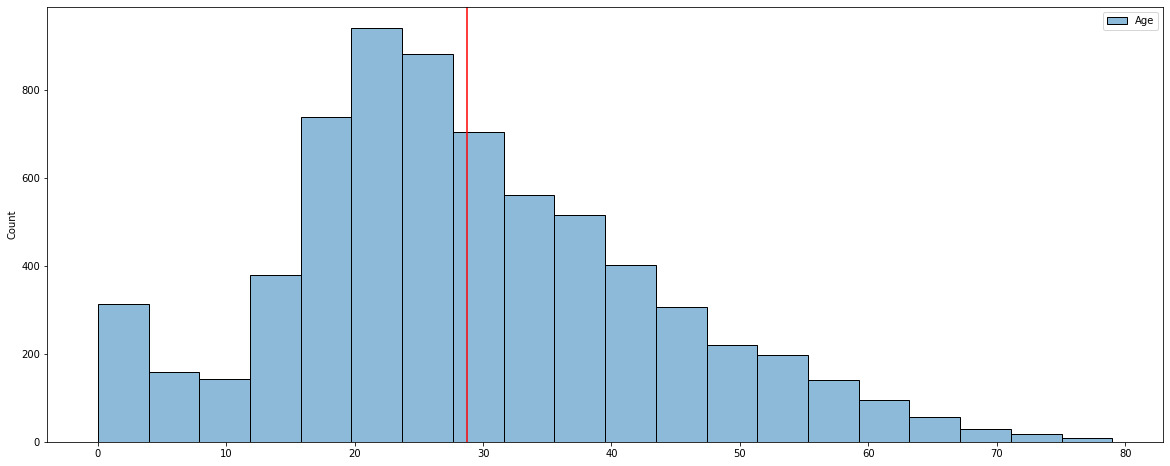

In [14]:
plt.figure(figsize=(20, 8))
sns.histplot(df_test.loc[:, ["Age"]], bins=20)
plt.axvline(df_test.Age.mean(), color='red')
plt.show()

In [15]:
# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
num_pipeline = Pipeline([
    # replace NA with mean
    ('imputer', SimpleImputer(strategy='mean')),
    # standardize the variables: z = (x - mean) / SD
    ('std_scaler', StandardScaler())])

In [16]:
age = num_pipeline.fit_transform(df_test.loc[:, ["Age"]])
print(f"Shape: {age.shape}")
print(f"number of NaN: {np.sum(np.isnan(age))}")

Shape: (6954, 1)
number of NaN: 0


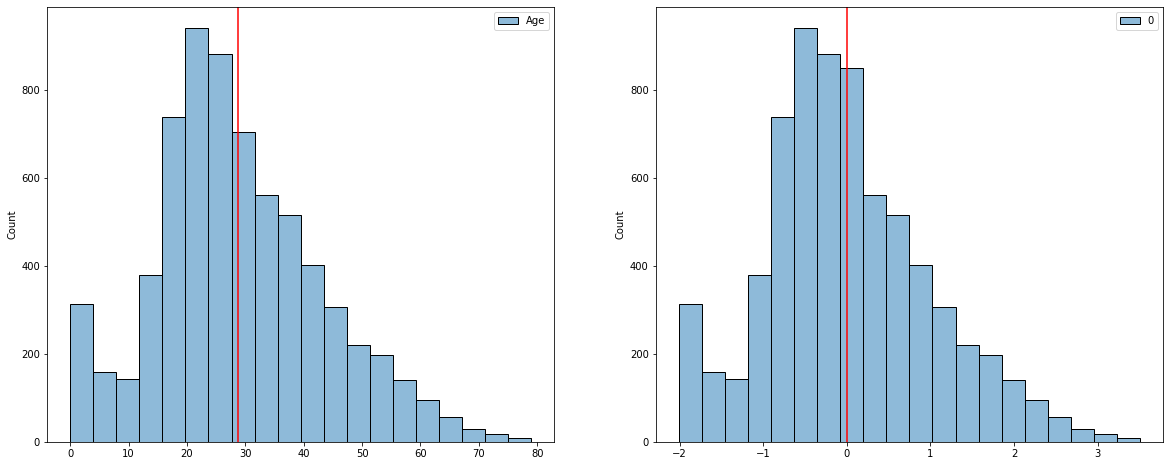

In [17]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sns.histplot(df_test.loc[:, ["Age"]], bins=20)
plt.axvline(df_test.Age.mean(), color='red')
plt.subplot(122)
sns.histplot(age, bins=20)
plt.axvline(age.mean(), color='red')
plt.show()

## cat_pipeline

It preprocesses the categorical attributed with `SimpleImputer()` and `OneHotEncoder()`.

In [18]:
# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
cat_pipeline = Pipeline([
    # replace NA with mode
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # apply "OneHotEncoder()"
    ('one_hot', OneHotEncoder(drop='if_binary'))])

In [19]:
pd.isna(df_test).sum(axis=0)

HomePlanet        165
CryoSleep         172
Destination       149
Age               145
VIP               154
RoomService       153
FoodCourt         158
ShoppingMall      166
Spa               146
VRDeck            145
group_size_bin      0
deck              159
side              159
amenities_sum       0
dtype: int64

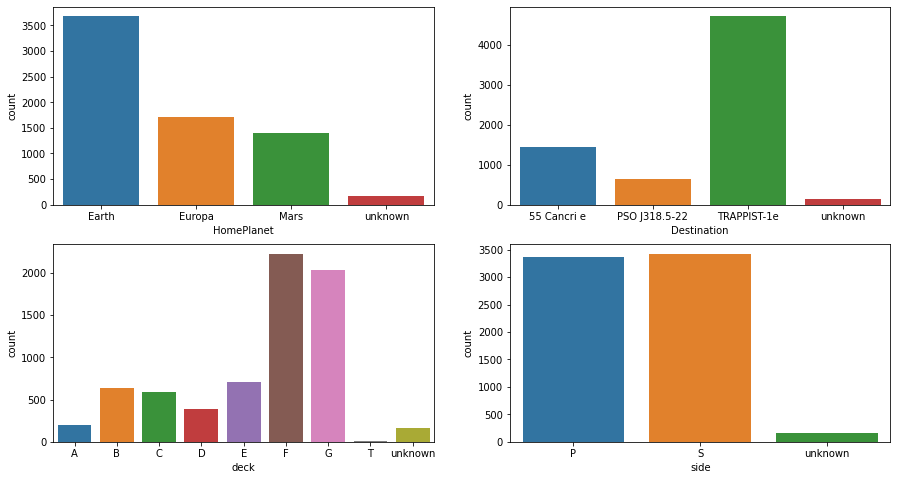

In [20]:
cat_with_nan = ["HomePlanet", "Destination", "deck", "side"]

plt.figure(figsize=(15 ,8))
for i, feature in enumerate(cat_with_nan):
    plot_me = (
        df_test.loc[:, feature]
       .value_counts(dropna=False)
       .rename("count")
       .reset_index()
       .rename(columns={"index":feature})
    )
    plot_me[plot_me.columns[0]] = (
        plot_me[plot_me.columns[0]]
        .cat
        .add_categories("unknown")
        .fillna("unknown")
    )
    plt.subplot(2, 2, i+1)
    sns.barplot(data=plot_me, x=feature, y="count")
plt.show()

In [21]:
cat_test = cat_pipeline.fit_transform(df_test.loc[:, ["HomePlanet"]])
print(f"Shape: {df_test.HomePlanet.shape}")
print(f"Shape: {cat_test.shape}")

Shape: (6954,)
Shape: (6954, 3)


## Combine pipelines

In [22]:
#list_num_attribs = ["Age"]
list_num_attribs = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "amenities_sum"]
#list_cat_attribs = ["HomePlanet", "CryoSleep", "Destination", "VIP",
#                    "group_size_bin", "deck", "side", "amenities_sum_bin"]
list_cat_attribs = ["HomePlanet", "CryoSleep", "Destination", "VIP",
                    "group_size_bin", "deck", "side"]

In [23]:
# ColumnTransformer requires tuples with:
# - a name
# - a transformer
# - a list of names (or indices) of columns to which the transformer is applied

cols_transformer = ColumnTransformer([
    # apply "num_pipeline" to numerical columns
    ('num', num_pipeline, list_num_attribs),
    # apply "cat_pipeline" to categorical columns
    ('cat', cat_pipeline, list_cat_attribs)
    ])

In [24]:
full_pipeline = Pipeline([
    # transform/add columns
    ('attribs_adder', CombinedAttributesAdder()),
    # Transform numerical and categorical attributes
    ("cols_transformer", cols_transformer)])

In [25]:
# print(full_pipeline.get_params().keys())
# print(full_pipeline.get_params().items())
print(full_pipeline.get_params())


{'memory': None, 'steps': [('attribs_adder', CombinedAttributesAdder()), ('cols_transformer', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck',
                                  'amenities_sum']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one_hot',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP', 'group

In [26]:
for i in full_pipeline.get_params().keys():
    print(i)

memory
steps
verbose
attribs_adder
cols_transformer
cols_transformer__n_jobs
cols_transformer__remainder
cols_transformer__sparse_threshold
cols_transformer__transformer_weights
cols_transformer__transformers
cols_transformer__verbose
cols_transformer__verbose_feature_names_out
cols_transformer__num
cols_transformer__cat
cols_transformer__num__memory
cols_transformer__num__steps
cols_transformer__num__verbose
cols_transformer__num__imputer
cols_transformer__num__std_scaler
cols_transformer__num__imputer__add_indicator
cols_transformer__num__imputer__copy
cols_transformer__num__imputer__fill_value
cols_transformer__num__imputer__keep_empty_features
cols_transformer__num__imputer__missing_values
cols_transformer__num__imputer__strategy
cols_transformer__num__imputer__verbose
cols_transformer__num__std_scaler__copy
cols_transformer__num__std_scaler__with_mean
cols_transformer__num__std_scaler__with_std
cols_transformer__cat__memory
cols_transformer__cat__steps
cols_transformer__cat__verbo

# Baseline model (log regression)

In [27]:
clf_baseline = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Logistic regression (with default paramenters)
    ("log_reg", LogisticRegression(random_state=123))])

In [28]:
clf_baseline.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'RoomService',
                                                                    'FoodCourt',
                                                                    'ShoppingMall',
                                                                    'Spa',
                                                                    'VRDeck',
                                                                    'amenities_sum']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(drop='if_binary'))]),
                                                                   ['HomePlanet',
                                                                    'CryoSleep',
                                                                    'Destination',
                                                                    'VIP',
                                                                    'group_size_bin',
                                                                    'deck',
                                                                    'side'])]))])),
                ('log_reg', LogisticRegression(random_state=123))])

In [29]:
y_pred_baseline = clf_baseline.predict(X_train)

## Define functions

In [30]:
def add_metrics(dictionary, y, y_pred, mod_name):
    # dictionary: a dictionary to which the metrics are added

    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    dictionary[mod_name] = {
        "accuracy": np.round(acc, 3),
        "confusion_matrix": cm,
        "precision": np.round(precision, 3),
        "recall": np.round(recall, 3),
        "f1_score": np.round(f1, 3)
    }

    return dictionary


def print_metrics(m):
    print(f"Accuracy is {m['accuracy']:.2f}.")
    print(f"When the model claims a passenger was transported to another dimension, it is correct {m['precision']*100} % of the time (precision).")
    print(f"The model detects {m['recall']*100:.2f} % of the passengers that were transported to another dimension (recall).")
    print(f"The F1 score is {m['f1_score']*100:.2f}.")



def display_cm(cm):
    # cm: a confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

## Metrics

In [31]:
models_score = dict()
models_score = add_metrics(models_score, y_train, y_pred_baseline, "baseline")

In [32]:
print_metrics(models_score["baseline"])

Accuracy is 0.79.
When the model claims a passenger was transported to another dimension, it is correct 78.10000000000001 % of the time (precision).
The model detects 80.90 % of the passengers that were transported to another dimension (recall).
The F1 score is 79.50.


In [33]:
models_score["baseline"]["confusion_matrix"]

array([[2671,  793],
       [ 665, 2825]], dtype=int64)

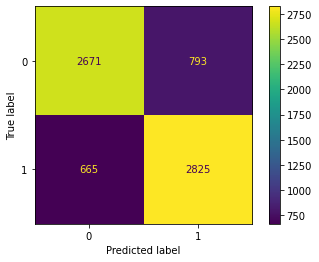

In [34]:
display_cm(models_score["baseline"]["confusion_matrix"])

# SGD Classifer

This results should be similar to the logistic regression model.

In [35]:
clf_sgd = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # LSGD Classifier (with default paramenters)
    ("sgd", SGDClassifier())])

In [36]:
clf_sgd.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'RoomService',
                                                                    'FoodCourt',
                                                                    'ShoppingMall',
                                                                    'Spa',
                                                                    'VRDeck',
                                                                    'amenities_sum']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(drop='if_binary'))]),
                                                                   ['HomePlanet',
                                                                    'CryoSleep',
                                                                    'Destination',
                                                                    'VIP',
                                                                    'group_size_bin',
                                                                    'deck',
                                                                    'side'])]))])),
                ('sgd', SGDClassifier())])

In [37]:
y_pred_sgd = clf_sgd.predict(X_train)

In [38]:
models_score = add_metrics(models_score, y_train, y_pred_sgd, "sgd")

In [39]:
print_metrics(models_score["sgd"])

Accuracy is 0.79.
When the model claims a passenger was transported to another dimension, it is correct 74.6 % of the time (precision).
The model detects 87.40 % of the passengers that were transported to another dimension (recall).
The F1 score is 80.50.


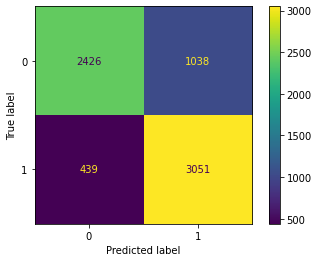

In [40]:
display_cm(models_score["sgd"]["confusion_matrix"])

# SVM

In [41]:
clf_svm = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # SVM Classifier
    ("SVM", LinearSVC(C=1, loss="hinge"))]) # dual=False

In [42]:
clf_svm.fit(X_train, y_train)

c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'RoomService',
                                                                    'FoodCourt',
                                                                    'ShoppingMall',
                                                                    'Spa',
                                                                    'VRDeck',
                                                                    'amenities_sum']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(drop='if_binary'))]),
                                                                   ['HomePlanet',
                                                                    'CryoSleep',
                                                                    'Destination',
                                                                    'VIP',
                                                                    'group_size_bin',
                                                                    'deck',
                                                                    'side'])]))])),
                ('SVM', LinearSVC(C=1, loss='hinge'))])

In [43]:
y_pred_svm = clf_svm.predict(X_train)

In [44]:
models_score = add_metrics(models_score, y_train, y_pred_svm, "svm")

In [45]:
print_metrics(models_score["svm"])

Accuracy is 0.80.
When the model claims a passenger was transported to another dimension, it is correct 79.3 % of the time (precision).
The model detects 80.40 % of the passengers that were transported to another dimension (recall).
The F1 score is 79.80.


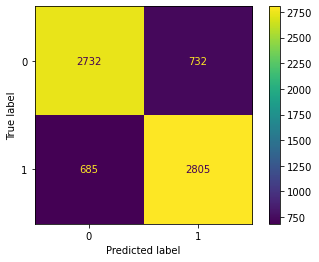

In [46]:
display_cm(models_score["svm"]["confusion_matrix"])

# SVM - Poly kernel

In [47]:
clf_svm_pk = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # SVM Classifier
    ("SVM", SVC(kernel="poly", degree=3))])

In [48]:
clf_svm_pk.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'RoomService',
                                                                    'FoodCourt',
                                                                    'ShoppingMall',
                                                                    'Spa',
                                                                    'VRDeck',
                                                                    'amenities_sum']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(drop='if_binary'))]),
                                                                   ['HomePlanet',
                                                                    'CryoSleep',
                                                                    'Destination',
                                                                    'VIP',
                                                                    'group_size_bin',
                                                                    'deck',
                                                                    'side'])]))])),
                ('SVM', SVC(kernel='poly'))])

In [49]:
y_pred_svm_pk = clf_svm_pk.predict(X_train)

In [50]:
models_score = add_metrics(models_score, y_train, y_pred_svm_pk, "svm_pk")

In [51]:
print_metrics(models_score["svm_pk"])

Accuracy is 0.80.
When the model claims a passenger was transported to another dimension, it is correct 81.8 % of the time (precision).
The model detects 78.30 % of the passengers that were transported to another dimension (recall).
The F1 score is 80.00.


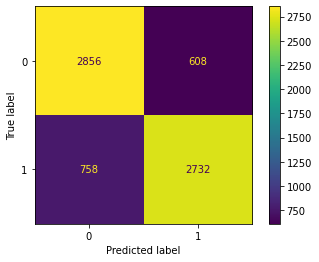

In [52]:
display_cm(models_score["svm_pk"]["confusion_matrix"])